In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [17]:
import torch
import numpy as np
from blending.utils.dataset import ImageDataBlending
from blending.utils.image import (_pil_image, get_image_laplacian_operator, get_blending_gradients,
                                  get_mixing_gradients, normalize_image)
from blending.utils.plots import plots_multiple_image_data, plots_multiple_tensor_image
from blending.models import VGG16_Model, MeanShift
from blending import blend
from argparse import Namespace

In [18]:
opt = Namespace(
    data_dir = 'data_blending',
    normalize = True,
    requires_grad = True,
    device = 'cpu'
)

device = torch.device(opt.device)

# Load Data

In [19]:
image_data_blending = ImageDataBlending(opt.data_dir, normalize=opt.normalize, device=device)

Getting Files:   0%|          | 0/8 [00:00<?, ?it/s]

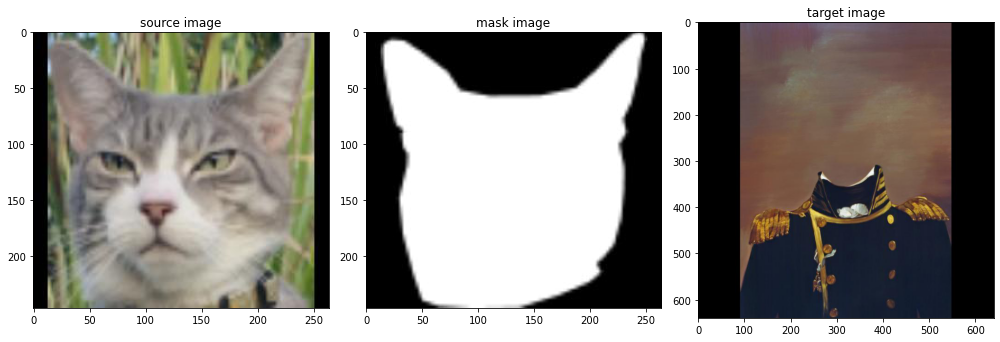

In [24]:
plots_multiple_image_data(image_data_blending[1], normalize=opt.normalize)

# Laplacian Operator

Laplacian operator $\nabla I$ over the image:

$$
\nabla = \begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix}
$$

In order to get the gradients of the images, we are going to define a convolutinal operation using the `laplacian matrix` as the kernel. Then make a convolution between the image, $I$, and the kernel $\nabla$

$$\begin{bmatrix}
     0 & -1 & 0 \\
     -1 & 4 & -1 \\
     0 & -1 & 0
\end{bmatrix} \circledast I$$

The following code will calculate each channel's gradients, and present it as plots 

## Gradients of source image

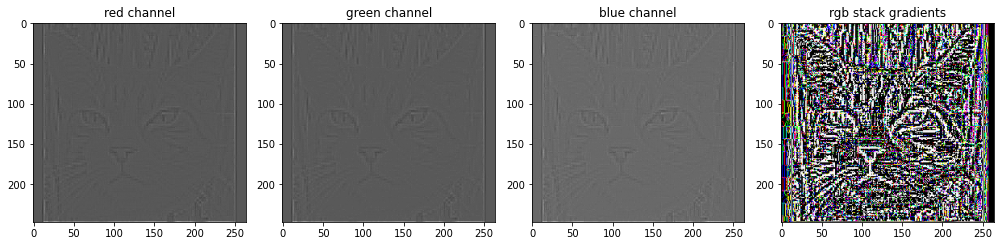

In [25]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[1]['source'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[1]['source'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                           normalize=opt.normalize)

## Gradients of target image

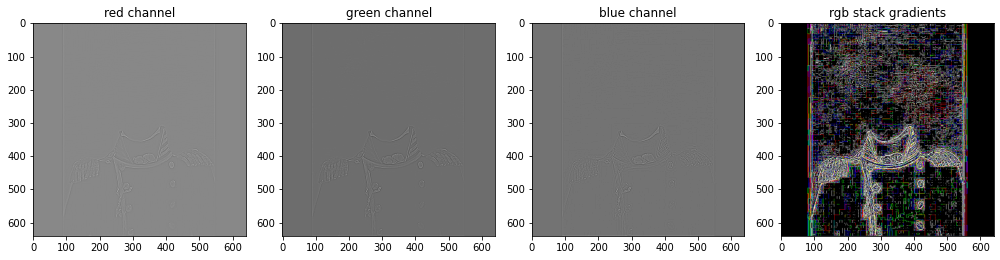

In [26]:
# Show each channel gradient
rgb_gradients_list = get_image_laplacian_operator(image_data_blending[1]['target'].unsqueeze(0), device=device)
rgb_gradients = torch.stack(rgb_gradients_list, dim=2).view(*image_data_blending[1]['target'].shape)
plots_multiple_tensor_image(*rgb_gradients_list, np.asarray(_pil_image(rgb_gradients)),
                            title_name=["red channel", "green channel", "blue channel", "rgb stack gradients"],
                            normalize=opt.normalize)

# Join Gradients

As we are going to blend both images `source` and `target`, we need to mix its gradients in order to optimize the following loss function:

$$L_{grad} = \frac{1}{2HW} \sum_{m=1}^{H}\sum_{n=1}^{W}[\nabla f(I_B) - (\nabla f(I_S) + \nabla f(I_T)]^{2}_{mn}$$

where $f$ is the blending function, $\nabla$ the laplacian operator, $I_S$ the source image and $I_T$ the target image. This loss function is over the gradients that means we are going to create a image such that optimize the previous loss grad

## Content loss function

For this content loss function we are going to use pretrained model VGG on imagenet, and this is define as:

$$L_{cont} = \sum_{l=1}^{L}\frac{\alpha_l}{2N_lM_l}\sum_{i=1}^{N_l}\sum_{k=1}^{M_l}(F_l[I_{Z}]\odot M - F_l[I_{S}])^{2}_{ik}$$

where $I_Z$ is the random Image that we are going to optimize, and $I_S$ is the source image. But the only layer we are going to use is the second activation layer before `MaxPool2d`

## TV (total variation) loss

The total variation (tv) loss is used to remove the un-wanted details while preserving the import information in the image. The loss objective is shown below.

$$L_{tv} = \sum_{m=1}^{H}\sum_{n=1}^{W}(|I_{m+1,n}-I_{m,n}| + |I_{m,n+1}-I_{m,n}|)$$

where $I$ is the blend image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


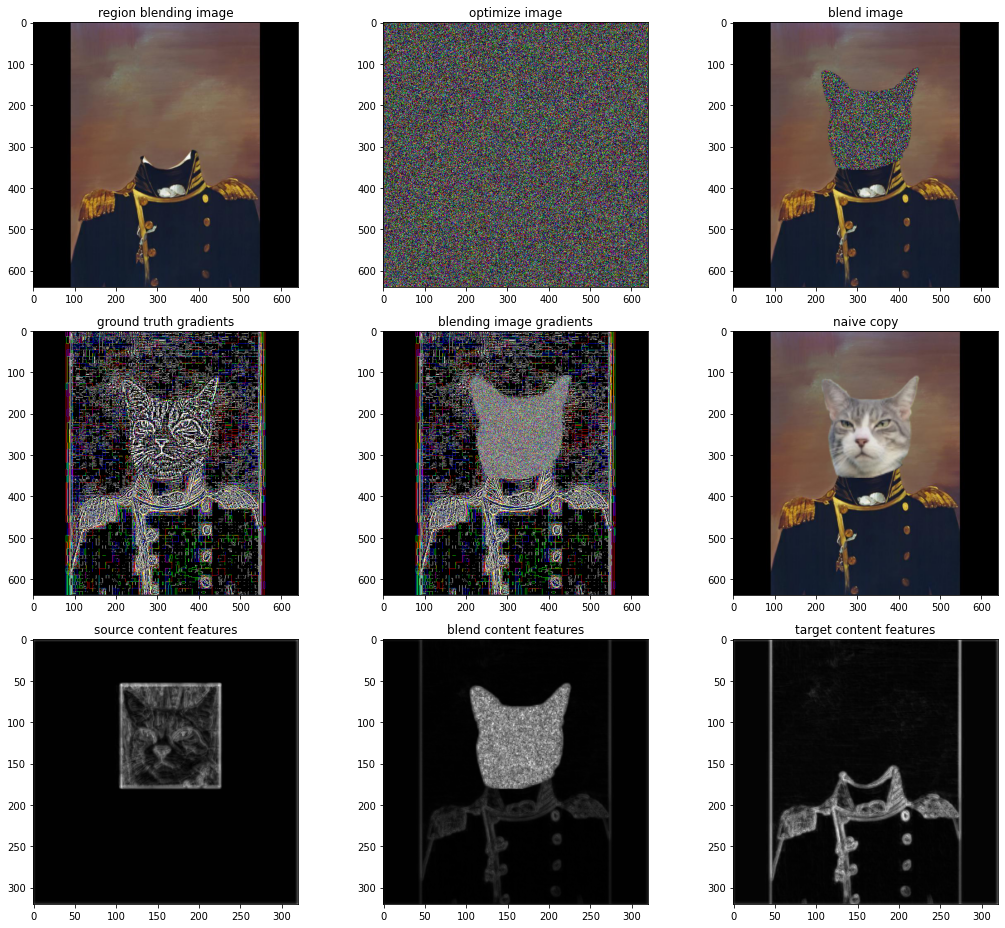

In [42]:
image_data = {
    'source': image_data_blending[1]['source'].unsqueeze(0),
    'target': image_data_blending[1]['target'].unsqueeze(0),
    'dims': image_data_blending[1]['dims'],
    'mask': image_data_blending[1]['mask'].unsqueeze(0)
}


target = image_data['target']
h, w = target.shape[2], target.shape[3]
dims = image_data['dims']

source = torch.zeros_like(target)
source[:, :, dims[0]:dims[1], dims[2]:dims[3]] = image_data['source']

mask = torch.zeros(1, 1, h, w)
mask[:,:, dims[0]:dims[1], dims[2]:dims[3]] = image_data['mask']


input_img = torch.randn(*source.shape, device=device).contiguous()
input_img.requires_grad = opt.requires_grad

tensor_image_target = target.clone()
blend_img = (input_img * mask + tensor_image_target * (1 - mask))
naive_copy = (source * mask + tensor_image_target * (1 - mask))

vgg16_features = VGG16_Model().to(device=device)
mean_shift = MeanShift().to(device=device)

# optimizer = torch.optim.LBFGS([input_img.requires_grad_()], lr=1.5, max_iter=200)
optimizer = torch.optim.LBFGS([input_img.requires_grad_()])
mse_loss = torch.nn.MSELoss().to(device=device)
lr_scheduler = torch.optim.ReduceLROnPlateau(optimizer, verbose=True)

new_image_data = {
    "mask": mask,
    "target": tensor_image_target,
    "source": source,
    "dims": dims
}

# plot tensor image
with torch.no_grad():
    source_features = vgg16_features(mean_shift(source))
    blend_features = vgg16_features(mean_shift(blend_img))
    target_features = vgg16_features(mean_shift(tensor_image_target))
    gt_gradients = torch.stack(get_mixing_gradients(new_image_data, device=device), dim=2).squeeze(0)
    blending_gradients = torch.stack(get_blending_gradients(new_image_data, blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(tensor_image_target, input_img, blend_img,
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(blending_gradients)),
                                naive_copy,
                                source_features.relu2_2.mean(dim=1),
                                blend_features.relu2_2.mean(dim=1),
                                target_features.relu2_2.mean(dim=1),
                                title_name=["region blending image",
                                            "optimize image",
                                            "blend image",
                                            "ground truth gradients",
                                            "blending image gradients",
                                           "naive copy",
                                           "source content features",
                                          "blend content features",
                                          "target content features"],
                                normalize=opt.normalize, figsize=(15,13), nrows=3)

In [ ]:
run = [0]
num_step = 1000
w_grad=1e5
w_content=1
w_tv=1e-6

while run[0] < num_step:
    def closure():
        optimizer.zero_grad()
        blend_img = (input_img * mask + tensor_image_target * (1 - mask))
        
        # Gradient loss
        blend_gradients = torch.stack(get_blending_gradients(new_image_data, blend_img, device=device), dim=2).squeeze(0)
        loss_grad = w_grad * mse_loss(blend_gradients, gt_gradients)
        
        # Content Loss
        # source_features = vgg16_features(mean_shift(source * mask))
        # blend_features = vgg16_features(mean_shift(blend_img * mask))
        source_features = vgg16_features(normalize_image(source * mask))
        blend_features = vgg16_features(normalize_image(blend_img * mask))
        loss_content = w_content * mse_loss(blend_features.relu2_2, source_features.relu2_2)
        
        # Source Loss
        loss_source = w_content * mse_loss(blend_img, naive_copy)
        
        # TV Reg Loss
        loss_tv = w_tv * (torch.sum(torch.abs(blend_img[:, :, :, :-1] - blend_img[:, :, :, 1:])) + 
                   torch.sum(torch.abs(blend_img[:, :, :-1, :] - blend_img[:, :, 1:, :])))
        
        # colect total loss
        loss_total = loss_grad + loss_content + loss_tv + loss_source
            
        if (run[0] + 1)%50 == 0 or (run[0] + 1 == 1):
            print("step: {}, loss_grad: {:.3f}, "
                  "loss_content: {:.3f}, "
                  "loss_tv: {:.5f}, "
                  "loss_source: {:.3f}, "
                  "loss_total: {:.3f}".format(run[0] + 1,
                                           loss_grad.item(),
                                           loss_content.item(),
                                           loss_tv.item(),
                                           loss_source.item(),
                                           loss_total.item()))
            with torch.no_grad():
                _pil_image(blend_img).save("results/iter_result/image_iter.jpg")
            
        run[0] += 1
        
        # Backward Optimization Step
        loss_total.backward()
        
        return loss_total
    
    # Optimize
    optimizer.step(closure)

step: 1, loss_grad: 188071.188, loss_content: 36.505, loss_tv: 0.27727, loss_source: 0.127, loss_total: 188108.094
step: 50, loss_grad: 5.978, loss_content: 1.460, loss_tv: 0.01760, loss_source: 0.033, loss_total: 7.489
step: 100, loss_grad: 1.795, loss_content: 0.579, loss_tv: 0.01583, loss_source: 0.031, loss_total: 2.421
step: 150, loss_grad: 1.068, loss_content: 0.398, loss_tv: 0.01553, loss_source: 0.030, loss_total: 1.511
step: 200, loss_grad: 0.782, loss_content: 0.329, loss_tv: 0.01542, loss_source: 0.028, loss_total: 1.155
step: 250, loss_grad: 0.657, loss_content: 0.290, loss_tv: 0.01533, loss_source: 0.027, loss_total: 0.989
step: 300, loss_grad: 0.585, loss_content: 0.262, loss_tv: 0.01527, loss_source: 0.025, loss_total: 0.887
step: 350, loss_grad: 0.542, loss_content: 0.239, loss_tv: 0.01523, loss_source: 0.023, loss_total: 0.819
step: 400, loss_grad: 0.513, loss_content: 0.220, loss_tv: 0.01521, loss_source: 0.021, loss_total: 0.770
step: 450, loss_grad: 0.495, loss_cont

## Plot results

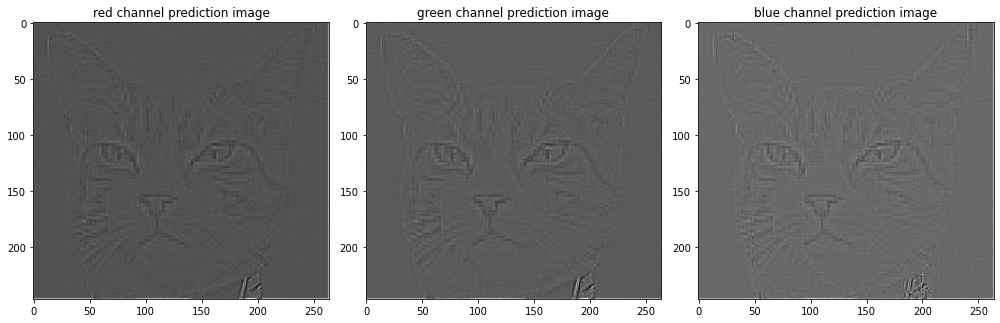

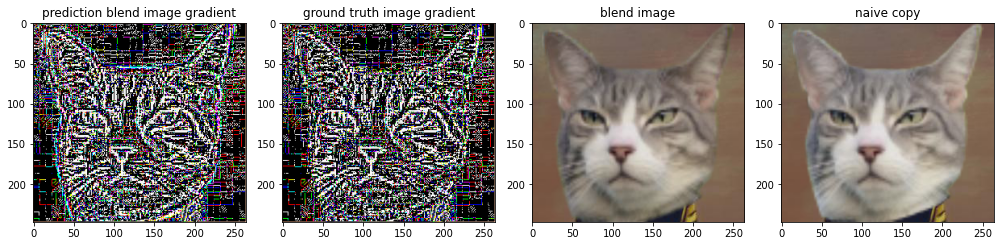

In [29]:
with torch.no_grad():
    blend_img = (input_img * mask + tensor_image_target * (1 - mask))
    blend_gradients = torch.stack(get_blending_gradients(image_data, blend_img, device=device), dim=2).squeeze(0)
    plots_multiple_tensor_image(*[blend_gradients[:, ch, :, :] for ch in range(3)],
                                title_name=["red channel prediction image",
                                           "green channel prediction image",
                                           "blue channel prediction image"], normalize=opt.normalize)
    plots_multiple_tensor_image(np.asarray(_pil_image(blend_gradients)),
                                np.asarray(_pil_image(gt_gradients)),
                                np.asarray(_pil_image(blend_img)),
                                np.asarray(_pil_image(naive_copy)), 
                                title_name=["prediction blend image gradient",
                                           "ground truth image gradient",
                                           "blend image",
                                           "naive copy"], normalize=opt.normalize)

# Full Image Blend

In [30]:
# target[:, :, dims[0]:dims[1], dims[2]:dims[3]] = blend_img

In [31]:
_pil_image(blend_img).save("results/final_result_first.jpg")

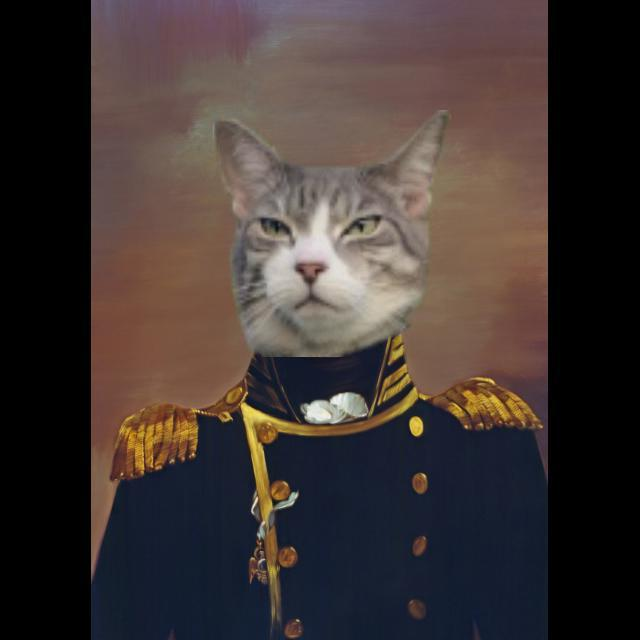

In [32]:
from IPython.display import Image
Image("results/final_result_first.jpg")